#**Melanoma Detection Assignment**

###**Problem Statement**###

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



####**Importing all the important libraries**


In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
root_path = 'drive/My Drive/CNN_Assignment'

In [15]:
data_dir_train = pathlib.Path(root_path+"/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(root_path+"/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2228
118


####**Load using keras.preprocessing**


Let's load these images off disk using the helpful image_dataset_from_directory utility.

####**Create a dataset**

Defining some parameters for the loader:

In [17]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2228 files belonging to 9 classes.
Using 1783 files for training.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2228 files belonging to 9 classes.
Using 445 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


###**Visualize the data**


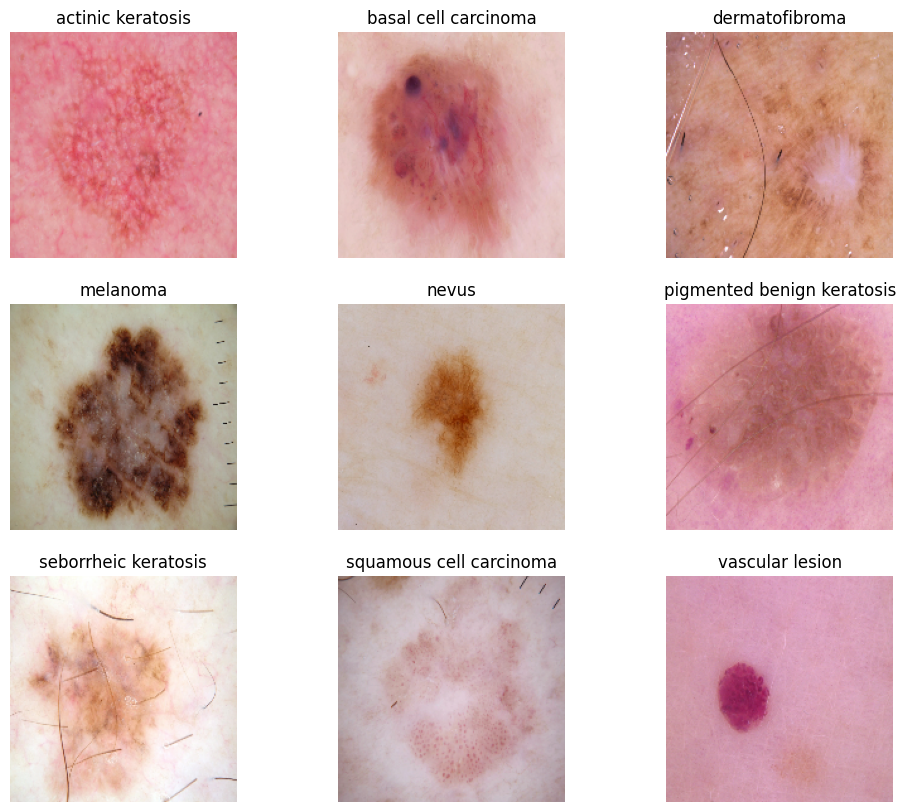

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

####**Create the model**


**Todo:** Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [24]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


####**Compile the model**

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

###**Train the model**

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 14s 174ms/step - loss: 1.9538 - accuracy: 0.3090 - val_loss: 1.6689 - val_accuracy: 0.4067
Epoch 2/20
56/56 [==============================] - 7s 117ms/step - loss: 1.5955 - accuracy: 0.4352 - val_loss: 1.6824 - val_accuracy: 0.3978
Epoch 3/20
56/56 [==============================] - 7s 118ms/step - loss: 1.4846 - accuracy: 0.4767 - val_loss: 1.6637 - val_accuracy: 0.3933
Epoch 4/20
56/56 [==============================] - 6s 115ms/step - loss: 1.3915 - accuracy: 0.5143 - val_loss: 1.5641 - val_accuracy: 0.4562
Epoch 5/20
56/56 [==============================] - 6s 116ms/step - loss: 1.2881 - accuracy: 0.5435 - val_loss: 1.4169 - val_accuracy: 0.5124
Epoch 6/20
56/56 [==============================] - 6s 114ms/step - loss: 1.2046 - accuracy: 0.5794 - val_loss: 1.4508 - val_accuracy: 0.5326
Epoch 7/20
56/56 [==============================] - 6s 116ms/step - loss: 1.1202 - accuracy: 0.6012 - val_loss: 1.4070 - val_accuracy: 0.5393
Epoch

####**Visualizing training results**

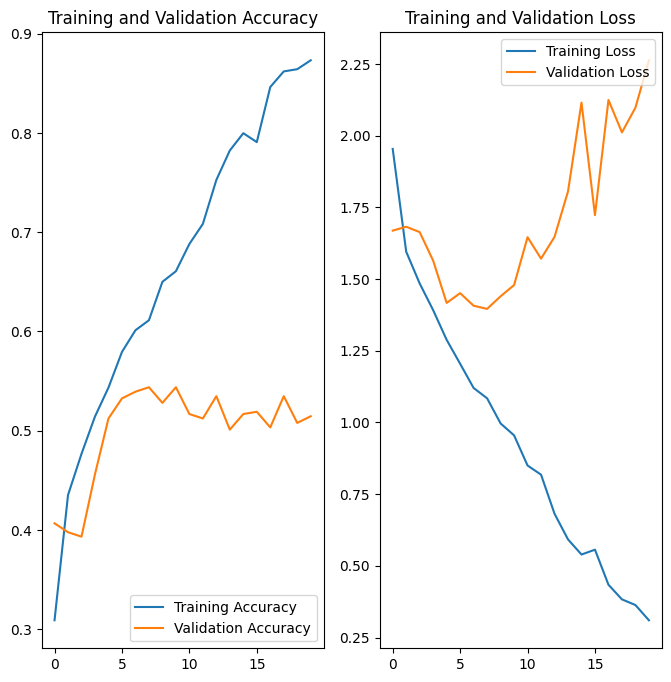

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


####**Findings**

1) From the above baseline model, We can clearly observe a significant difference between the training and validation accuracy, indicating that the model has **overfitted**. <br>
2) The validation accuracy suddenly drops at 50%, that indicates base model is under performed and not suitable for test validation.

####**Performing Data Augmentation**

Data augmentation is a technique used to increase the diversity of training dataset by applying various transformations to the existing data. This is useful in CNN, as it helps improve the model's generalization and robustness, reducing overfitting.

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

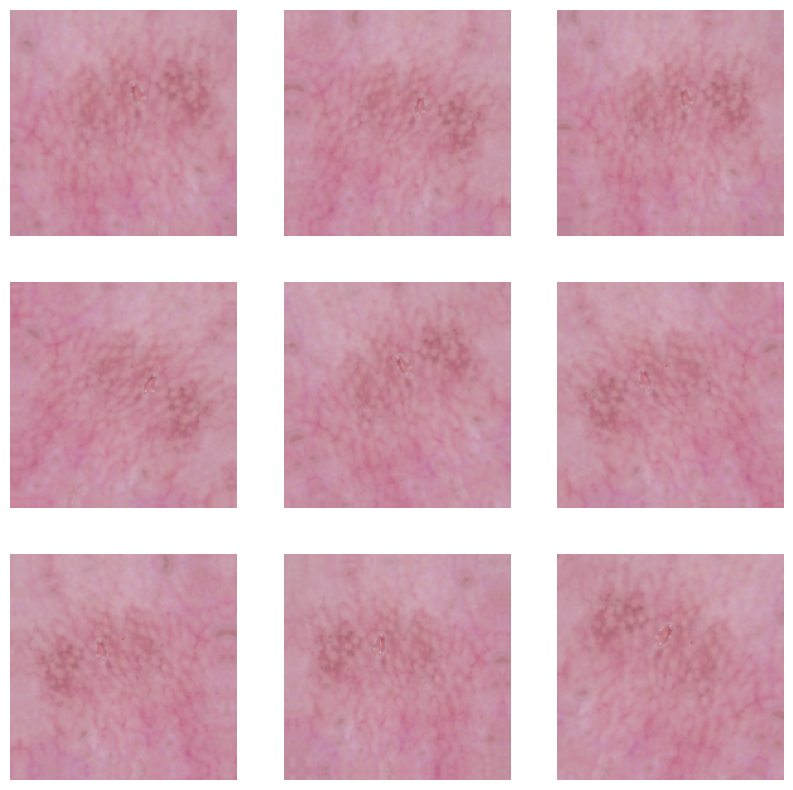

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

####**Create the model, compile and train the model**

In [32]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


####**Compling the model with data augmentation**

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#####**Training the Model**

In [34]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 132ms/step - loss: 2.1405 - accuracy: 0.2098 - val_loss: 1.9085 - val_accuracy: 0.2966
Epoch 2/20
56/56 [==============================] - 7s 128ms/step - loss: 1.8752 - accuracy: 0.3023 - val_loss: 1.8412 - val_accuracy: 0.3258
Epoch 3/20
56/56 [==============================] - 7s 125ms/step - loss: 1.8223 - accuracy: 0.3236 - val_loss: 1.7017 - val_accuracy: 0.3933
Epoch 4/20
56/56 [==============================] - 7s 125ms/step - loss: 1.6355 - accuracy: 0.4167 - val_loss: 1.6224 - val_accuracy: 0.4135
Epoch 5/20
56/56 [==============================] - 7s 125ms/step - loss: 1.5245 - accuracy: 0.4689 - val_loss: 1.5185 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 7s 128ms/step - loss: 1.4616 - accuracy: 0.4947 - val_loss: 1.4725 - val_accuracy: 0.5169
Epoch 7/20
56/56 [==============================] - 7s 123ms/step - loss: 1.4073 - accuracy: 0.5008 - val_loss: 1.3665 - val_accuracy: 0.5371
Epoch 

####**Visualizing the results**

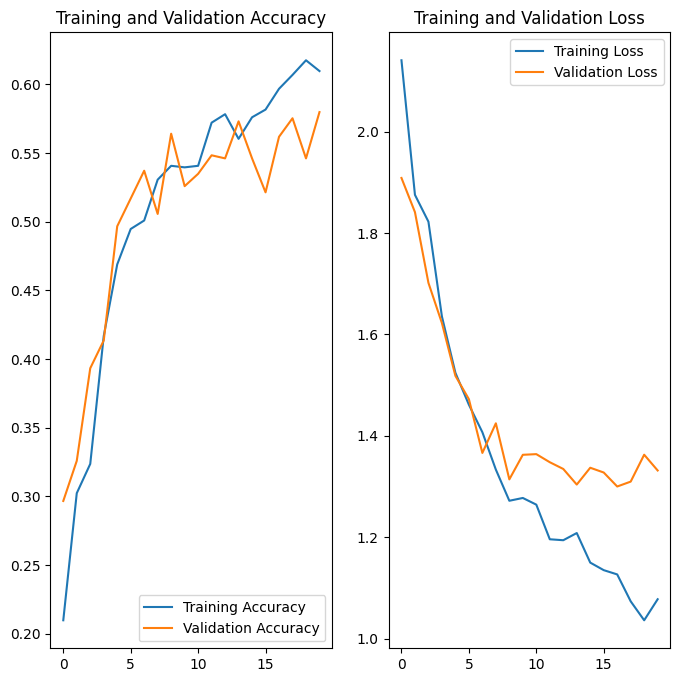

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


###**Findings**

As observed from model training with data augmentation, the training and validation accuracy are now nearly identical, with the highest accuracy reaching 60%. This demonstrates the positive impact of data augmentation on model performance. However, there is still room to further improve the model's accuracy.

####**Finding the distribution of classes in the training dataset.**

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [36]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,vascular lesion
1,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,vascular lesion
2,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,vascular lesion
3,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,vascular lesion
4,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,vascular lesion
...,...,...
2234,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,actinic keratosis
2235,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,actinic keratosis
2236,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,actinic keratosis
2237,drive/My Drive/CNN_Assignment/Skin cancer ISIC...,actinic keratosis


Class=8, n=139 (6.208%)
Class=7, n=181 (8.084%)
Class=6, n=77 (3.439%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=3, n=438 (19.562%)
Class=2, n=95 (4.243%)
Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)


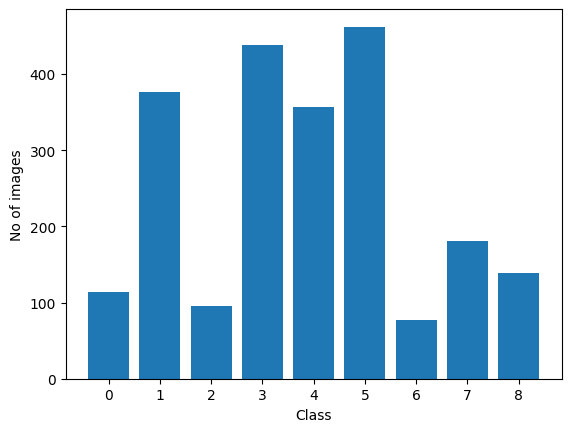

In [37]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()


####**Findings**

**- Which class has the least number of samples?** <br>
      As depecited in Bar chart, class=6 with 3.43% has the least number of samples in the dataset. <br>
**- Which classes dominate the data in terms proportionate number of samples?** <br> Class=5 domniates the data with 20.63% samples, which contributes high number of samples.

####**Rectifying the class imbalance**

**Context:**Using python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

In [39]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7889E86887F0>: 100%|██████████| 500/500 [00:04<00:00, 117.43 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x788A0833A0B0>: 100%|██████████| 500/500 [00:04<00:00, 110.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788B7C4E8C10>: 100%|██████████| 500/500 [00:04<00:00, 117.67 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7889E8679390>: 100%|██████████| 500/500 [00:06<00:00, 81.08 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788B6C7EAAD0>: 100%|██████████| 500/500 [00:06<00:00, 78.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788B6C688160>: 100%|██████████| 500/500 [00:04<00:00, 104.11 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x788B6C7EB4C0>: 100%|██████████| 500/500 [00:05<00:00, 96.33 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788B6C688190>: 100%|██████████| 500/500 [00:05<00:00, 96.94 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x789379BE4670>: 100%|██████████| 500/500 [00:05<00:00, 94.82 Samples/s] 


In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


####**Lets see the distribution of augmented data after adding new images to the original training data.**


In [41]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026349.jpg_a73407b1-1e52-4ea5-950c-e5975b327c2f.jpg',
 'drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031719.jpg_139233ba-ad62-4b02-aff2-71c6fabb9aed.jpg',
 'drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_72b0a0d3-045f-4994-8ff6-bc20407fbba7.jpg',
 'drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_8a183777-18d8-4851-a1a0-93de494cb51d.jpg',
 'drive/My Drive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026393.jpg_1eb

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion']

In [43]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([df, df2], ignore_index=True)

In [46]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

Added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####**Training the model on the data created using Augmentor**

In [47]:
batch_size = 32
img_height = 180
img_width = 180

####**Creating a training dataset**

In [48]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####**Creating a validation dataset**

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [50]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
169/169 [==============================] - 23s 134ms/step - loss: 0.6213 - accuracy: 0.7698 - val_loss: 0.7022 - val_accuracy: 0.7476
Epoch 2/30
169/169 [==============================] - 24s 137ms/step - loss: 0.6045 - accuracy: 0.7750 - val_loss: 0.6634 - val_accuracy: 0.7699
Epoch 3/30
169/169 [==============================] - 23s 135ms/step - loss: 0.5694 - accuracy: 0.7871 - val_loss: 0.6006 - val_accuracy: 0.7869
Epoch 4/30
169/169 [==============================] - 24s 137ms/step - loss: 0.5973 - accuracy: 0.7815 - val_loss: 0.7408 - val_accuracy: 0.7320
Epoch 5/30
169/169 [==============================] - 23s 135ms/step - loss: 0.5421 - accuracy: 0.7964 - val_loss: 0.7487 - val_accuracy: 0.7476
Epoch 6/30
169/169 [==============================] - 24s 138ms/step - loss: 0.5382 - accuracy: 0.7958 - val_loss: 0.8143 - val_accuracy: 0.7335
Epoch 7/30
169/169 [==============================] - 24s 136ms/step - loss: 0.5013 - accuracy: 0.8103 - val_loss: 0.6533 - val_ac

####**Visualizing the results**

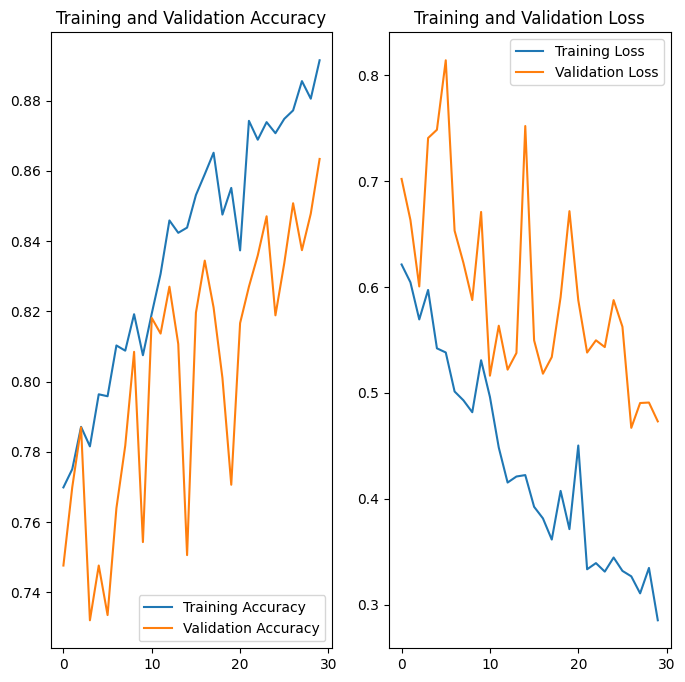

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####**Conculsion**

We can finalize that the model is well-fitted with a enough accuracy of 89% for both training and 86% of validation data. Addressing class imbalance and applying data augmentation have significantly improved the model's accuracy and mitigated overfitting. This indicates that the model is good enough for predicting skin cancer using a CNN.